In [6]:
import pandas as pd
import numpy as np
import ppscore as pps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import IsolationForest

In [7]:
file_path = r"C:\Users\acer\Downloads\EDA2\EDA2\adult_with_headers.csv"
df = pd.read_csv(file_path)

In [8]:
display(df.head())
print("Dataset Info:")
df.info()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [9]:
df.columns = df.columns.str.strip()

In [10]:
print("Column Names:", df.columns.tolist())

Column Names: ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']


In [11]:
df = df.replace(' ?', np.nan)  
df.dropna(inplace=True) 

In [13]:
scaler = StandardScaler()
df_standard_scaled = df.copy()
df_standard_scaled[['capital_gain', 'capital_loss', 'hours_per_week']] = scaler.fit_transform(
    df_standard_scaled[['capital_gain', 'capital_loss', 'hours_per_week']]
)


In [14]:
minmax_scaler = MinMaxScaler()
df_minmax_scaled = df.copy()
df_minmax_scaled[['capital_gain', 'capital_loss', 'hours_per_week']] = minmax_scaler.fit_transform(
    df_minmax_scaled[['capital_gain', 'capital_loss', 'hours_per_week']]
)


In [15]:
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if df[col].nunique() <= 5:
        df = pd.get_dummies(df, columns=[col], drop_first=True)  
    else:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])  

In [16]:
df['capital_diff'] = df['capital_gain'] - df['capital_loss']  # New feature combining capital gain & loss
df['hours_per_week_bin'] = pd.cut(df['hours_per_week'], bins=3, labels=['low', 'medium', 'high'])

In [17]:
df['log_capital_gain'] = np.log1p(df['capital_gain'])

In [18]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(df.select_dtypes(include=[np.number]))
df = df[outliers == 1]  

In [19]:
pps_matrix = pps.matrix(df)
print("PPS Score Matrix:")
display(pps_matrix.sort_values(by=['ppscore'], ascending=False))

PPS Score Matrix:


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,age,age,1.0,predict_itself,True,None,0.0000,1.000000,None
198,capital_loss,capital_loss,1.0,predict_itself,True,None,0.0000,1.000000,None
66,education,education,1.0,predict_itself,True,None,0.0000,1.000000,None
67,education,education_num,1.0,regression,True,mean absolute error,1.8002,0.000000,DecisionTreeRegressor()
87,education_num,education,1.0,regression,True,mean absolute error,2.5348,0.000000,DecisionTreeRegressor()
...,...,...,...,...,...,...,...,...,...
179,capital_gain,native_country,0.0,regression,True,mean absolute error,1.1720,2.175517,DecisionTreeRegressor()
178,capital_gain,hours_per_week,0.0,regression,True,mean absolute error,6.9536,7.322056,DecisionTreeRegressor()
177,capital_gain,capital_loss,0.0,regression,True,mean absolute error,97.0302,182.911921,DecisionTreeRegressor()
12,age,race_ Asian-Pac-Islander,0.0,regression,True,mean absolute error,0.0180,0.035478,DecisionTreeRegressor()


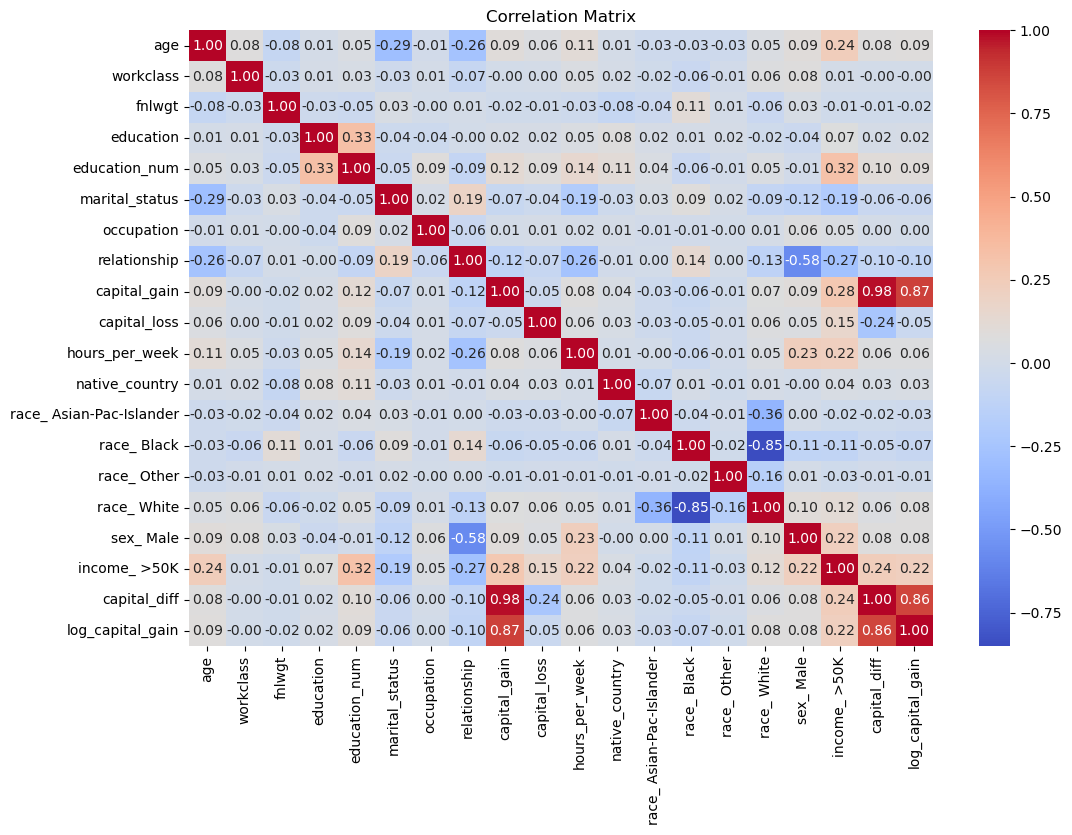

Data Preprocessing, Feature Engineering, and Feature Selection completed successfully!


In [20]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

print("Data Preprocessing, Feature Engineering, and Feature Selection completed successfully!")